In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from enum import Enum
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, \
                            f1_score, confusion_matrix

# Versão do código do desafio refatorado pelo chatGPT

In [9]:
df = pd.read_csv('sensor.csv')

In [3]:
df.shape

(220320, 55)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [10]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('sensor_15', axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 53 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       210112 non-null  float64       
 2   sensor_01       219951 non-null  float64       
 3   sensor_02       220301 non-null  float64       
 4   sensor_03       220301 non-null  float64       
 5   sensor_04       220301 non-null  float64       
 6   sensor_05       220301 non-null  float64       
 7   sensor_06       215522 non-null  float64       
 8   sensor_07       214869 non-null  float64       
 9   sensor_08       215213 non-null  float64       
 10  sensor_09       215725 non-null  float64       
 11  sensor_10       220301 non-null  float64       
 12  sensor_11       220301 non-null  float64       
 13  sensor_12       220301 non-null  float64       
 14  sensor_13       220301 non-null  flo

In [12]:
class MachineStatus(Enum):
    NORMAL = 1
    BROKEN = 2
    RECOVERING = 3

status_map = {
    'NORMAL': MachineStatus.NORMAL.value,
    'BROKEN': MachineStatus.BROKEN.value,
    'RECOVERING': MachineStatus.RECOVERING.value
}

df['machine_status'] = df['machine_status'].map(status_map)
df.head(5)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,1
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,1
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,1
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,1


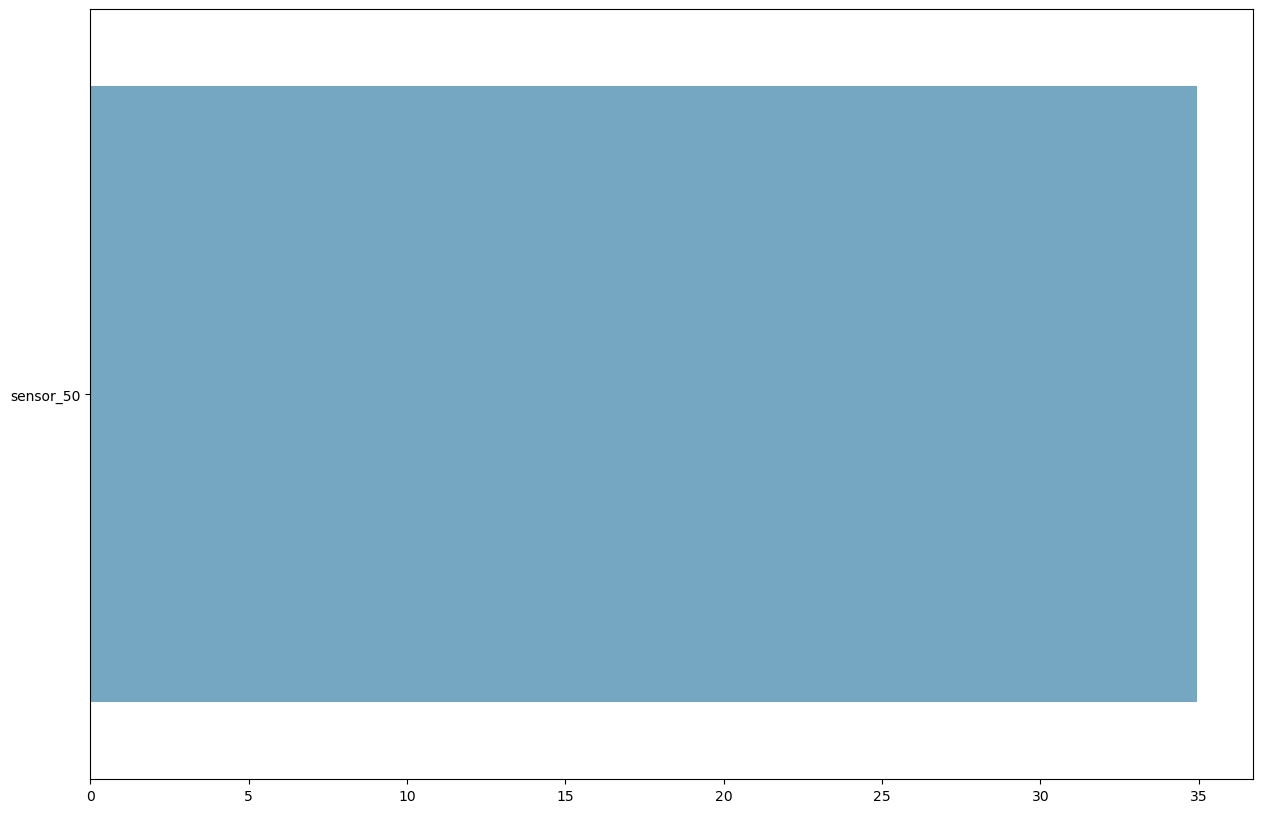

In [13]:
# Compute the percentage of missing values for each column
missing_pct = df.isnull().mean() * 100

# Select columns with more than 10% missing values
high_missing_pct_cols = missing_pct[missing_pct > 10].index.tolist()

# Plot the percentage of missing values for selected columns
ax = sns.barplot(x=missing_pct[high_missing_pct_cols], y=high_missing_pct_cols, palette='PuBuGn_r')
ax.figure.set_size_inches(15, 10)

# Add percentage labels to the bars
for p in ax.patches:
    x = p.get_x() + p.get_width() + 3
    y = p.get_y() + p.get_height() / 2
    ax.annotate('{:.1f}%'.format(p.get_width()), (x, y), ha='center')

In [14]:
df.drop('sensor_50', axis=1, inplace=True)

In [38]:
for sensor in df.columns[1:-1]:
    mean = df[sensor].mean()
    df[sensor].fillna(mean, inplace=True)

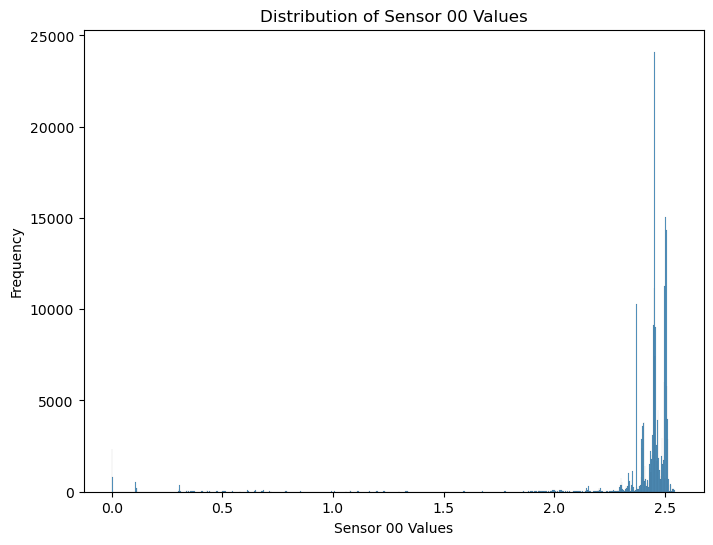

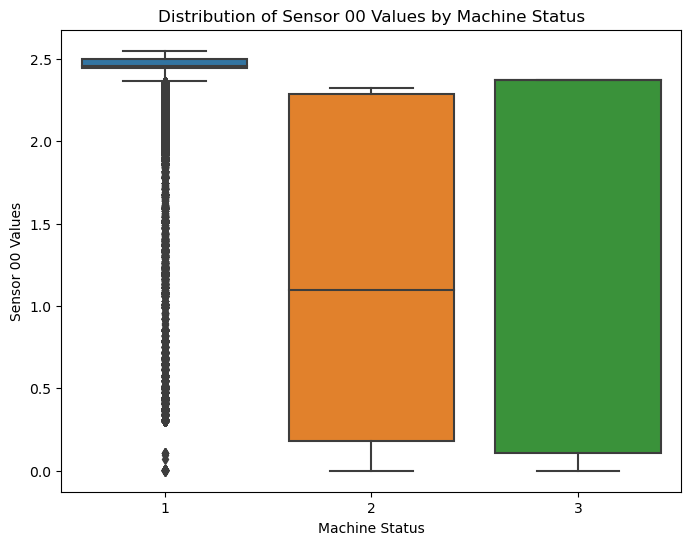

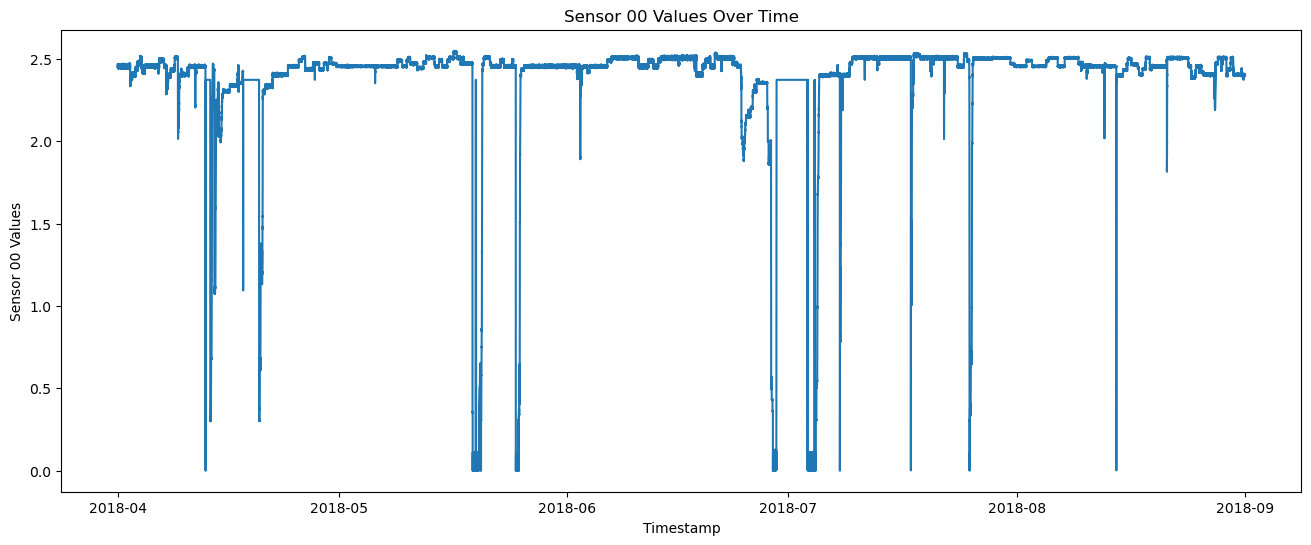

In [39]:
# plot a histogram of the sensor_00 column
plt.figure(figsize=(8, 6))
sns.histplot(df['sensor_00'], kde=False)
plt.title('Distribution of Sensor 00 Values')
plt.xlabel('Sensor 00 Values')
plt.ylabel('Frequency')
plt.show()

# plot a boxplot of the sensor_00 column, grouped by machine_status
plt.figure(figsize=(8, 6))
sns.boxplot(x='machine_status', y='sensor_00', data=df)
plt.title('Distribution of Sensor 00 Values by Machine Status')
plt.xlabel('Machine Status')
plt.ylabel('Sensor 00 Values')
plt.show()

# plot a line chart of the sensor_00 column over time
plt.figure(figsize=(16, 6))
sns.lineplot(x='timestamp', y='sensor_00', data=df)
plt.title('Sensor 00 Values Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Sensor 00 Values')
plt.show()

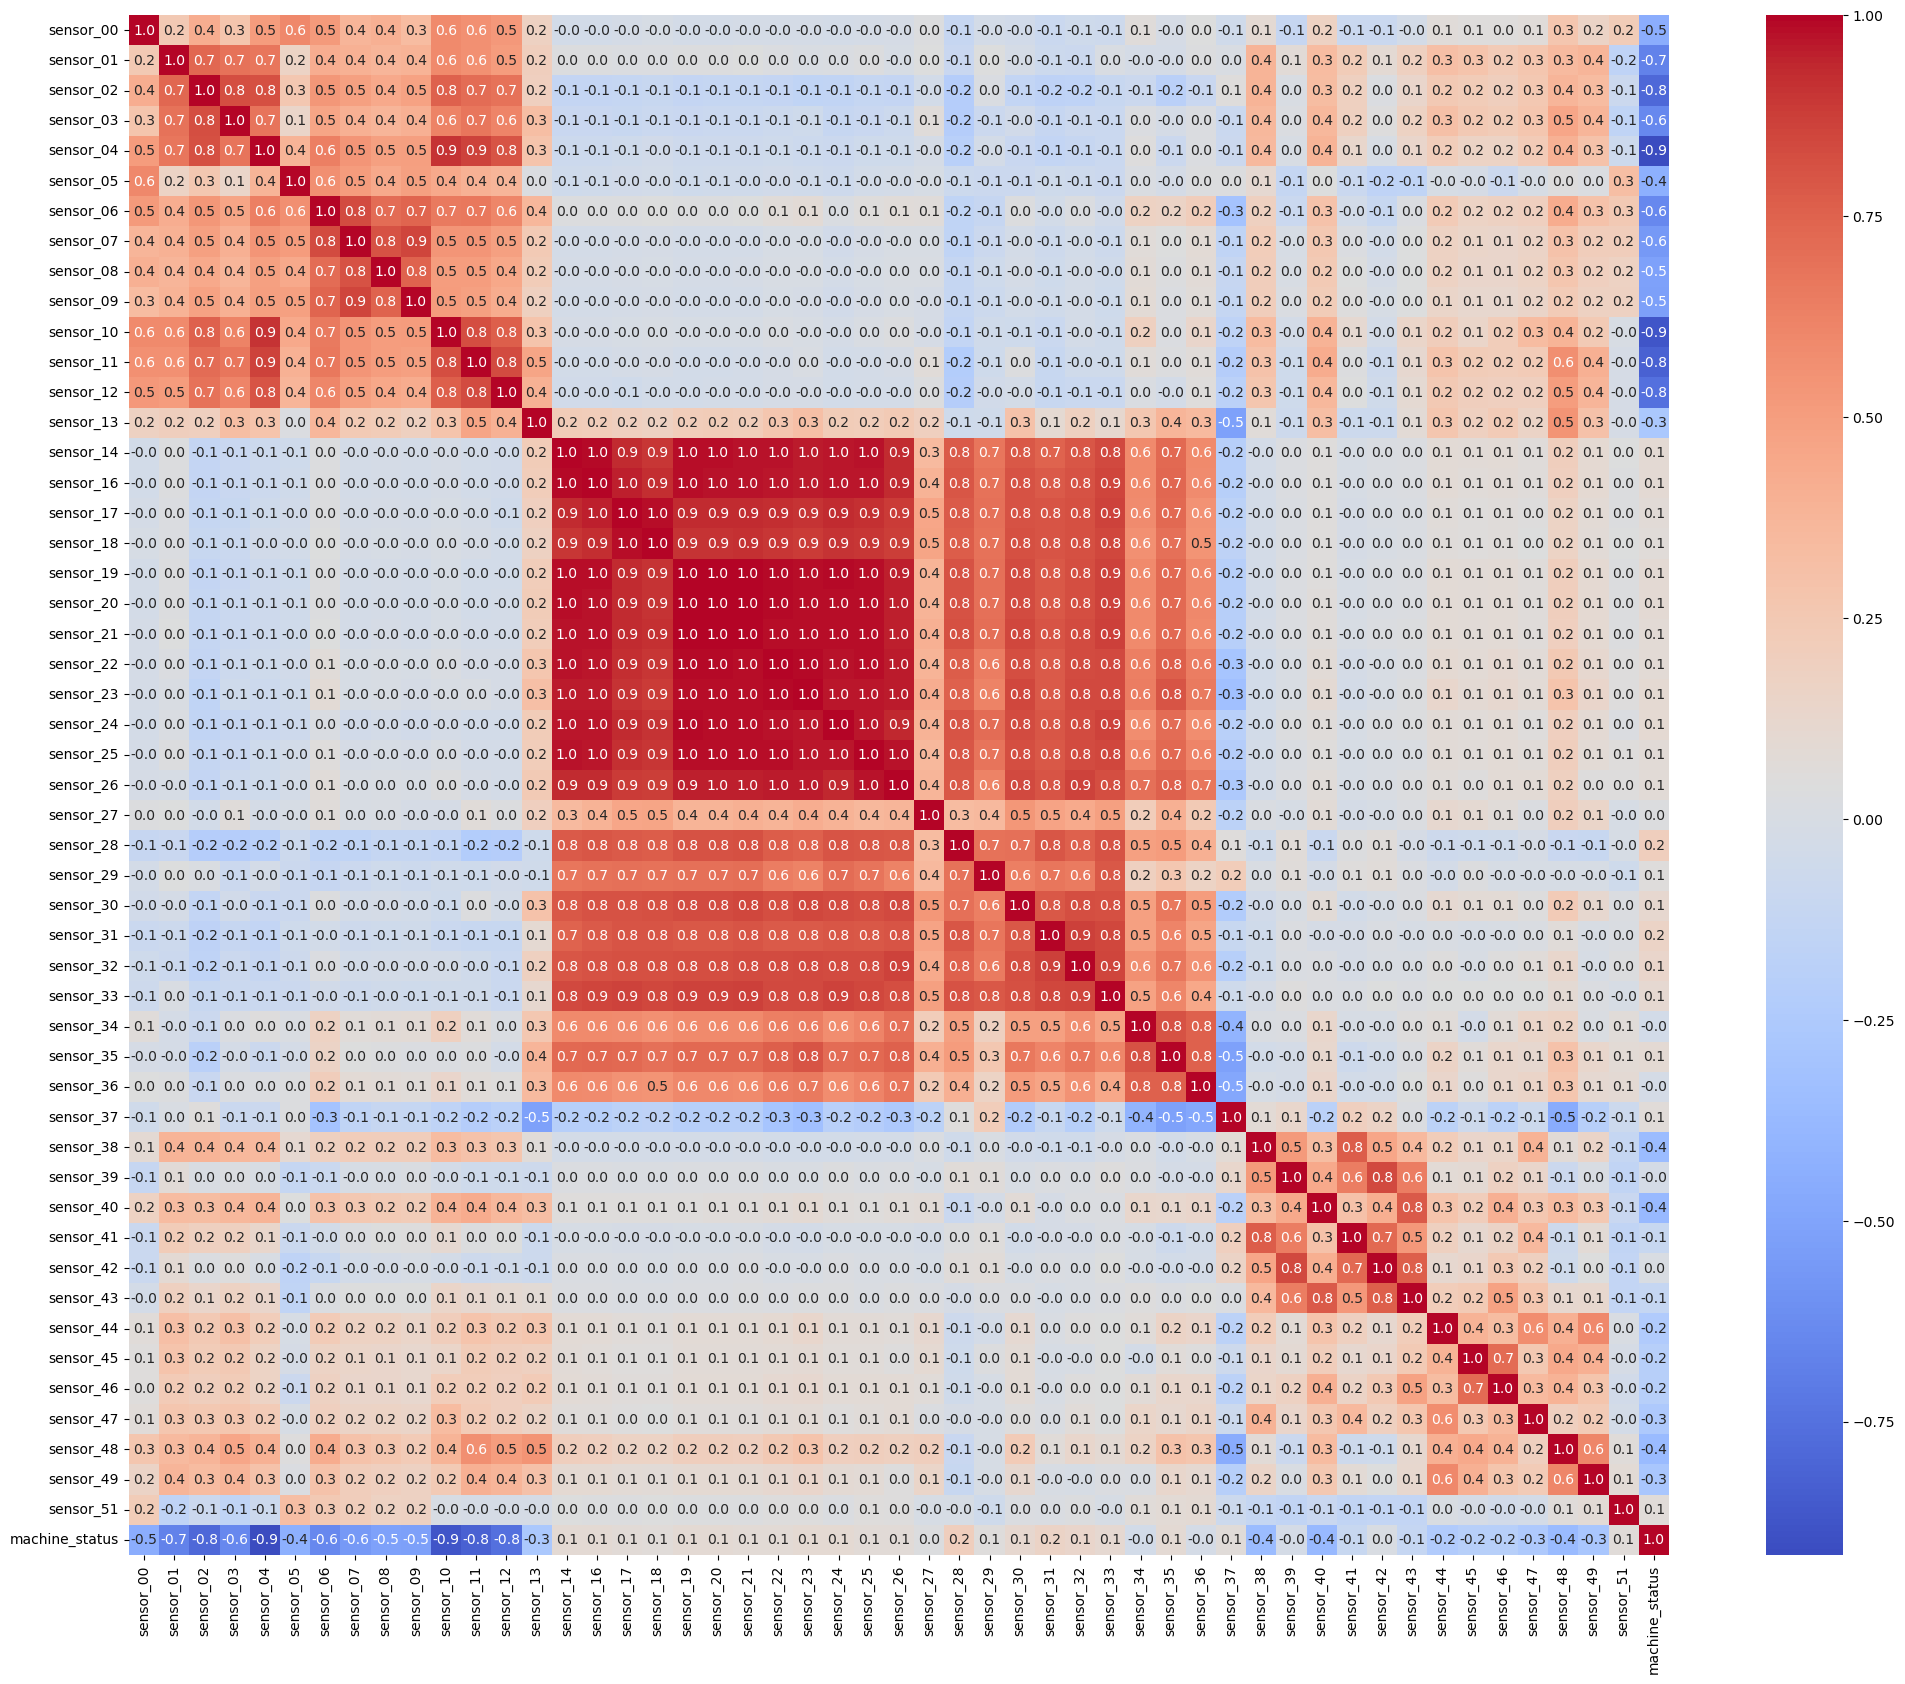

In [43]:
plt.figure(figsize=(25, 20))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f', square=True)
plt.show()

In [44]:
df['machine_normal'] = (df['machine_status'] == MachineStatus.NORMAL.value).astype(int)

In [45]:
df.groupby(['machine_status'])['machine_normal'].sum()

machine_status
1    205836
2         0
3         0
Name: machine_normal, dtype: int32

In [47]:
class DayPeriod(Enum):
  EARLY_MORNING = 0
  MORNING = 1
  NOON = 2
  AFTERNOON = 3
  EVENING = 4
  NIGHT = 5
    
# use pd.cut() to create the day_period column
df['day_period'] = pd.cut(
    df['timestamp'].dt.hour,
    bins=[-1, 4, 8, 12, 16, 20, 24],
    labels=[d.value for d in DayPeriod]
)

# print unique day periods
print(df['day_period'].unique())

[0, 1, 2, 3, 4, 5]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


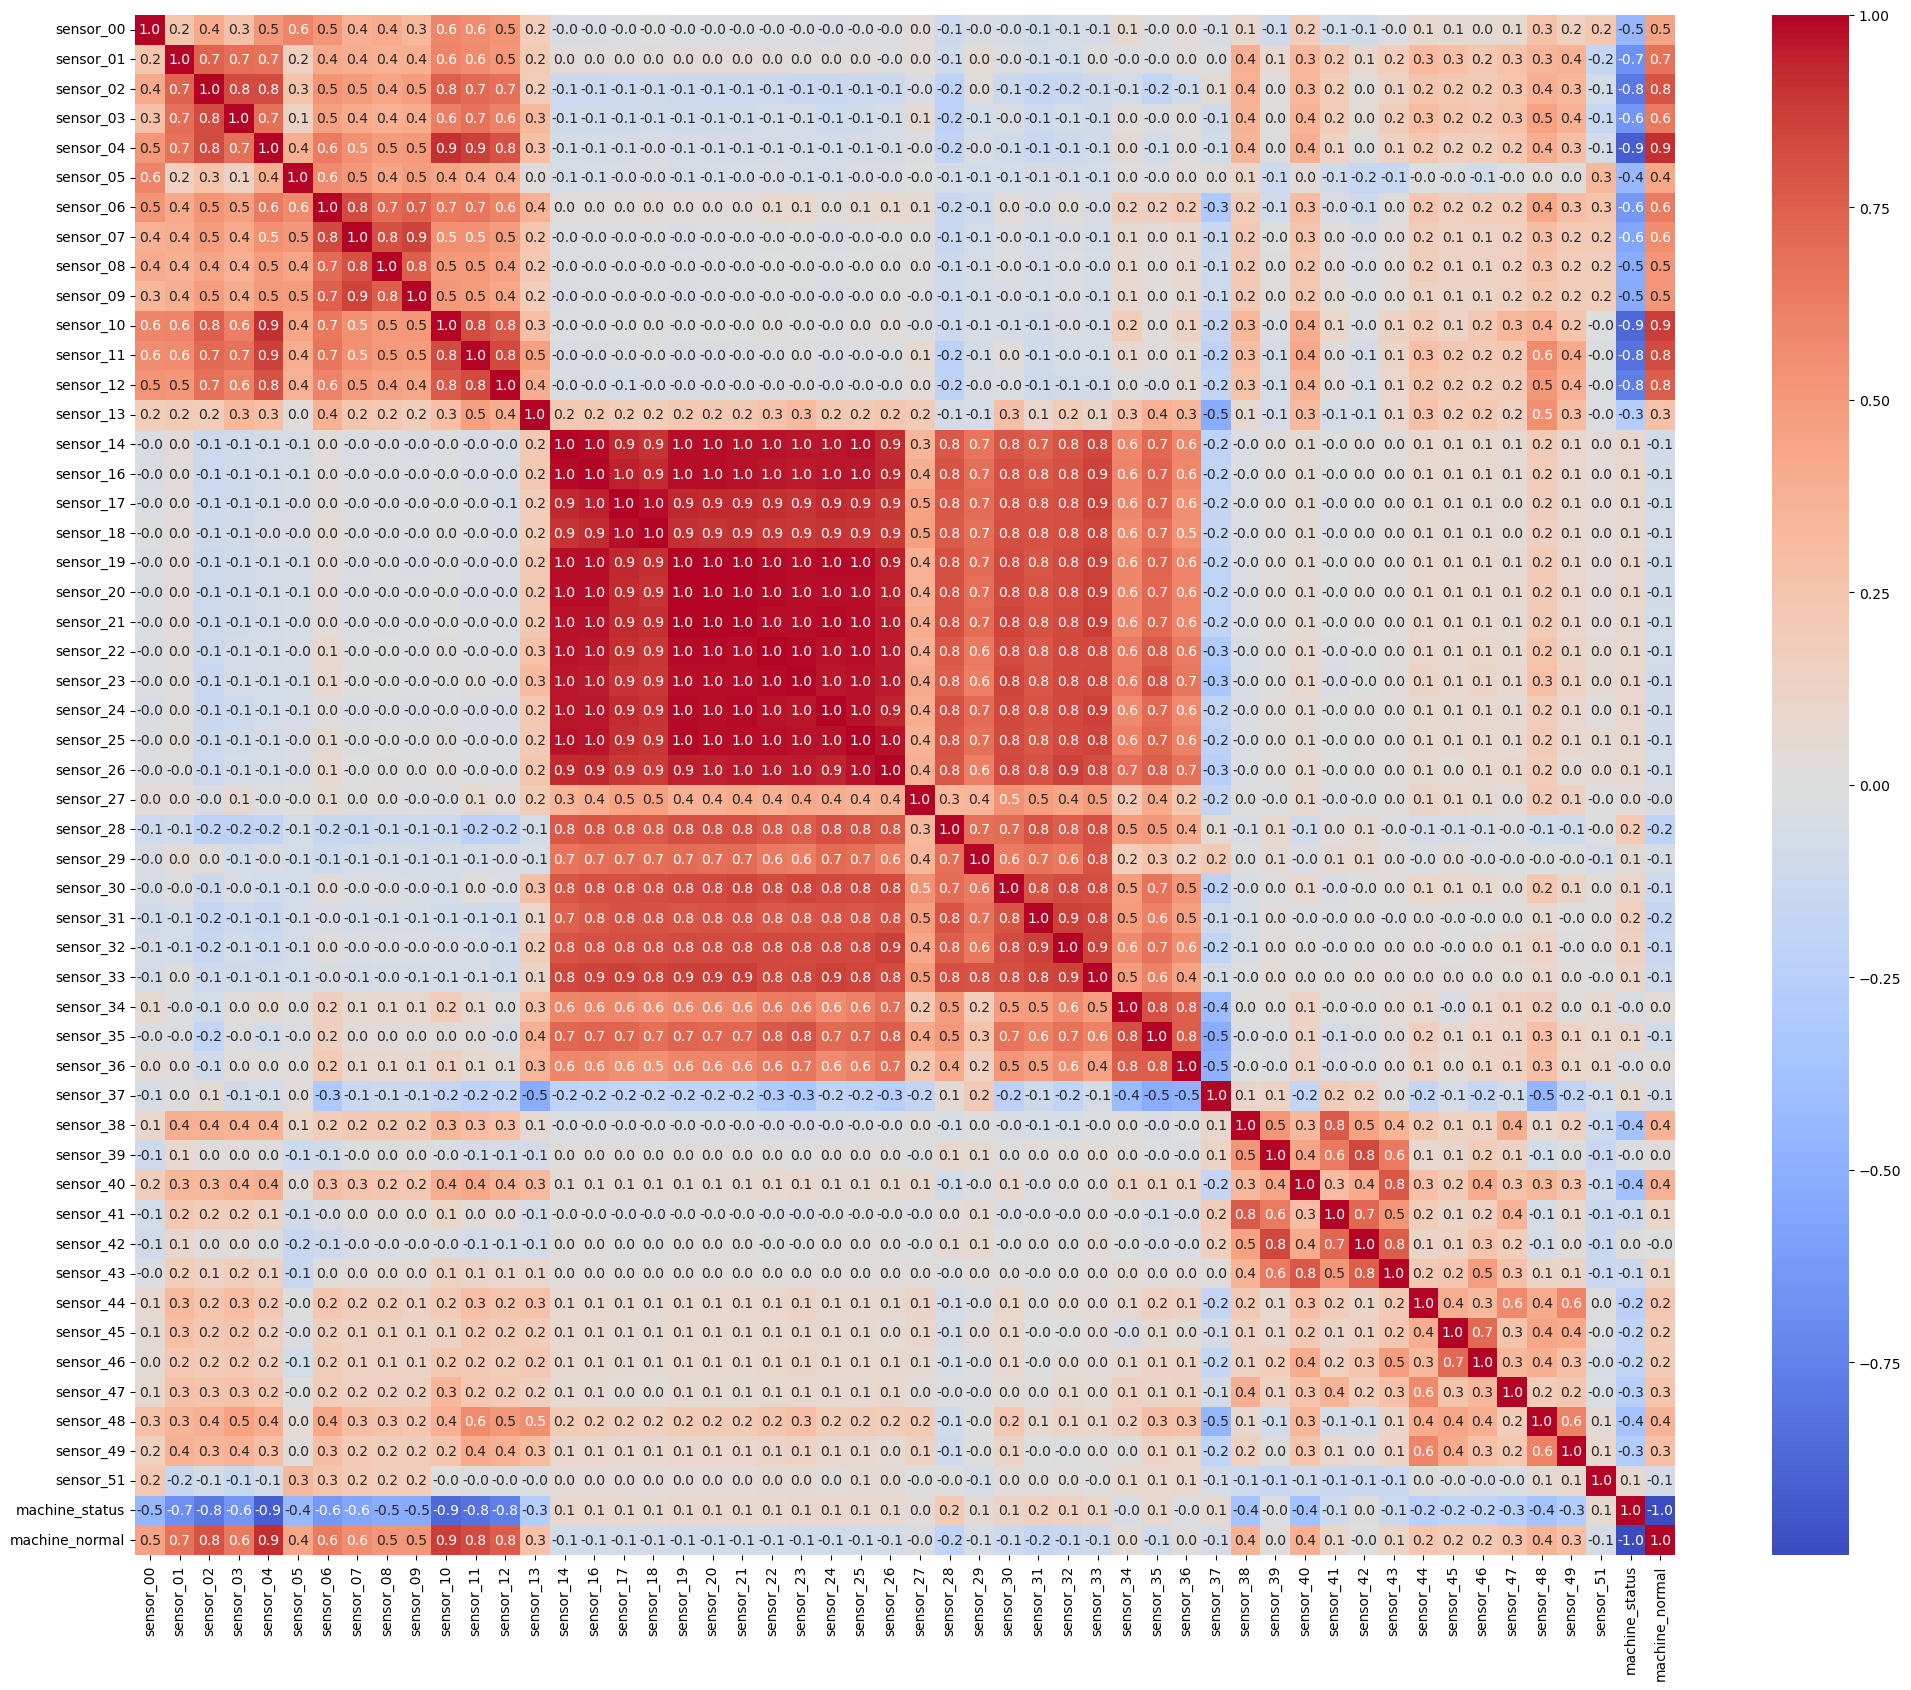

In [48]:
plt.figure(figsize=(25, 20))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.1f', square=True)
plt.show()

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   timestamp       220320 non-null  datetime64[ns]
 1   sensor_00       220320 non-null  float64       
 2   sensor_01       220320 non-null  float64       
 3   sensor_02       220320 non-null  float64       
 4   sensor_03       220320 non-null  float64       
 5   sensor_04       220320 non-null  float64       
 6   sensor_05       220320 non-null  float64       
 7   sensor_06       220320 non-null  float64       
 8   sensor_07       220320 non-null  float64       
 9   sensor_08       220320 non-null  float64       
 10  sensor_09       220320 non-null  float64       
 11  sensor_10       220320 non-null  float64       
 12  sensor_11       220320 non-null  float64       
 13  sensor_12       220320 non-null  float64       
 14  sensor_13       220320 non-null  flo

In [53]:
X = df.iloc[:, 1:-3].values
y = df['machine_normal'].values
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.02995114 0.03313877 0.04216067 0.03449017 0.19804782 0.07980064
 0.02053264 0.0172028  0.01541501 0.02553253 0.11544947 0.11764753
 0.09515398 0.01443183 0.00240124 0.0008654  0.00034093 0.00069952
 0.00167678 0.00190948 0.00078873 0.00167424 0.00332245 0.00099803
 0.00225782 0.0021524  0.0007574  0.0030386  0.00273901 0.001585
 0.00218582 0.002857   0.00083923 0.00171327 0.00228584 0.00502556
 0.00124921 0.00863773 0.00836161 0.00575956 0.01009532 0.00835964
 0.00239056 0.00120446 0.00206852 0.00326356 0.0026262  0.02980447
 0.01161612 0.02349431]


In [54]:
most_important = [(sensor, importance) for sensor, importance in zip(df.columns[1:-2], model.feature_importances_) if importance >= 0.01]
most_important = sorted(most_important, key=lambda x: x[1], reverse=True)

In [55]:
most_important

[('sensor_04', 0.1980478212655411),
 ('sensor_11', 0.11764752868858386),
 ('sensor_10', 0.11544947485190567),
 ('sensor_12', 0.09515397845682141),
 ('sensor_05', 0.07980064272601509),
 ('sensor_02', 0.04216067442425481),
 ('sensor_03', 0.03449016541340896),
 ('sensor_01', 0.033138767527658756),
 ('sensor_00', 0.029951138920474407),
 ('sensor_48', 0.02980446538667197),
 ('sensor_09', 0.025532528274410122),
 ('sensor_51', 0.02349430956611774),
 ('sensor_06', 0.020532640820164434),
 ('sensor_07', 0.017202795220568258),
 ('sensor_08', 0.015415010472824781),
 ('sensor_13', 0.014431829647768367),
 ('sensor_49', 0.011616115016987187),
 ('sensor_41', 0.010095316085441463)]

In [56]:
# get the list of important sensors
important_sensors = [sensor for sensor, importance in most_important]

# create a new dataframe with the important sensors, machine_status, and machine_normal columns
df_reduced = df.loc[:, important_sensors + ['machine_status', 'machine_normal']].copy()

# print the info of the new dataframe
print(df_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_04       220320 non-null  float64
 1   sensor_11       220320 non-null  float64
 2   sensor_10       220320 non-null  float64
 3   sensor_12       220320 non-null  float64
 4   sensor_05       220320 non-null  float64
 5   sensor_02       220320 non-null  float64
 6   sensor_03       220320 non-null  float64
 7   sensor_01       220320 non-null  float64
 8   sensor_00       220320 non-null  float64
 9   sensor_48       220320 non-null  float64
 10  sensor_09       220320 non-null  float64
 11  sensor_51       220320 non-null  float64
 12  sensor_06       220320 non-null  float64
 13  sensor_07       220320 non-null  float64
 14  sensor_08       220320 non-null  float64
 15  sensor_13       220320 non-null  float64
 16  sensor_49       220320 non-null  float64
 17  sensor_41 

Text(0, 0.5, 'Sensor 00')

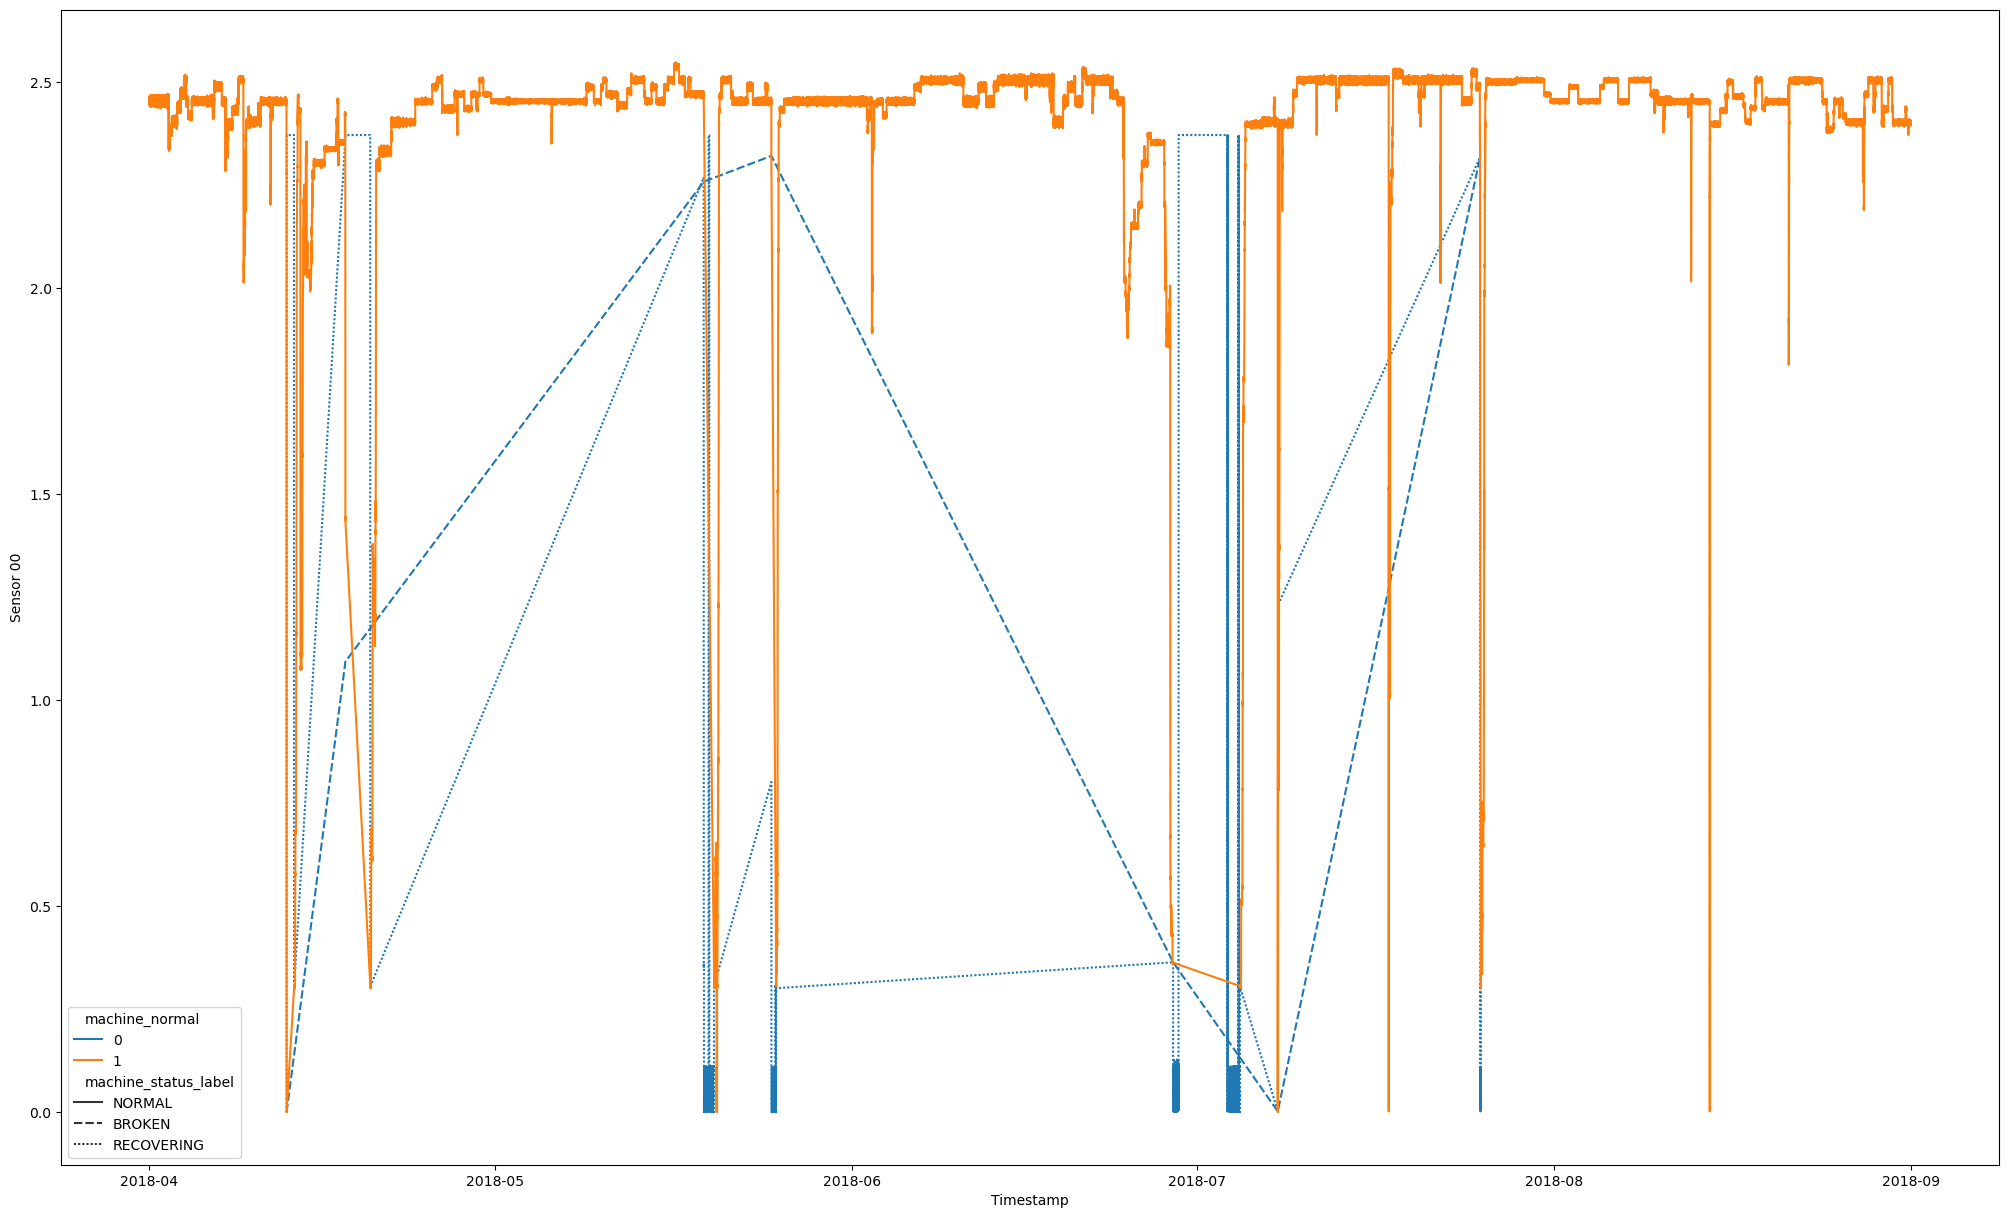

In [60]:
df_reduced = df[[sensor for sensor, _ in most_important] + ['machine_status', 'machine_normal', 'timestamp']].copy()
df_reduced['machine_status_label'] = df_reduced['machine_status'].apply(lambda x: MachineStatus(x).name)

fig, ax = plt.subplots(figsize=(25, 15))
sns.lineplot(x='timestamp', y='sensor_00',
             hue='machine_normal', style='machine_status_label',
             data=df_reduced, ax=ax)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Sensor 00')

In [63]:
# Extract sensor columns from most_important
sensor_cols = [sensor for sensor, _ in most_important]

# Keep relevant columns
data = df_reduced[[*sensor_cols, 'timestamp', 'machine_normal']].copy()

# Separate features and target variable
X = data.drop(columns=['machine_normal']).values
y = data['machine_normal'].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Get number of features
n_features = X_train.shape[1]

In [64]:
model = Sequential([
    Dense(10, activation='relu', input_shape=(n_features,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/25
4131/4131 [==============================] - 12s 3ms/step - loss: 0.0488 - accuracy: 0.9823 - val_loss: 0.0100 - val_accuracy: 0.9967
Epoch 2/25
4131/4131 [==============================] - 10s 2ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0055 - val_accuracy: 0.9989
Epoch 3/25
4131/4131 [==============================] - 9s 2ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 4/25
4131/4131 [==============================] - 11s 3ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0028 - val_accuracy: 0.9991
Epoch 5/25
4131/4131 [==============================] - 12s 3ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 6/25
4131/4131 [==============================] - 9s 2ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0022 - val_accuracy: 0.9991
Epoch 7/25
4131/4131 [==============================] - 10s 2ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0040 - val_accu

In [66]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 1.000


In [68]:
def evaluate_model(proba, y_test, y_pred):
    s1 = accuracy_score(y_test, y_pred).round(3)
    s2 = precision_score(y_test, y_pred, average='weighted').round(3)
    s3 = recall_score(y_test, y_pred, average='weighted').round(3)
    s4 = f1_score(y_test, y_pred, average='weighted').round(3)
    s5 = roc_auc_score(y_test, proba, average='weighted').round(3)
    print("Accuracy ", s1)
    print("Precision ", s2)
    print("Recall ", s3)
    print("f1 score ", s4)
    print("ROC_AUC ", s5)

mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=50, activation='relu', solver='adam', random_state=42)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

prob = mlp.predict_proba(X_test)[:,1]

evaluate_model(prob, y_test, y_pred)

Accuracy  1.0
Precision  1.0
Recall  1.0
f1 score  1.0
ROC_AUC  1.0
